<a href="https://colab.research.google.com/github/FerDoranNie/ColabNotebooks/blob/master/Technical_Assessment_Data_Scientist_Fernando_Dorantes_Nieto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entropy - Technical Assessment
For the position of Data Scientist.


## Objective
Build a model/algorithm that inputs a given budget and generates the daily ideal budget distribution across the paid media channels that maximizes sales given a user specified date that can be up to a month.

## Considerations
The provided datasets are paid media channels from an ecommerce store. You have to use the datasets to generate a model that maximizes the sales given X daily budget.

The dataset may include errors and outliers, make sure you clean up the data as you see fit.

## Bonus Points
I've added a datasets that includes conversion rate and sessions for the last ~5 years, this extends further the the media channel data, feel free to use it as the base for a seasonility model to further improve the predictions of the sales forecast predictions based on allocated budget. If using the seasonality data, you may of course, request a date for the budget recommendation and sales prediction so you can adjust results accordingly.

## Rules
* Assessment results has to be explained and commented in english.
* Please use Google Colab so I can easily review and run your work.
* Make sure your code executes correctly... Will disqualify candidates if code doesnt work.
* Its ok to take inspiration in others people (or AI) work, but please be ready to fully explain your thoughts behind your work. I prefer you use things you fully comprehend, instead of using foreign code & ideas that you dont fully understand.
* I will choose the best candidates based on my own judgement, but I will value explainability, creativity and elegance of the solution.

## Questions
Contact arturo@entropy.tech for any questions.

## Dataset
https://drive.google.com/file/d/17u9_ih3r3Q8q3N8uQ2Cy3AZdKdttHUg7/view?usp=sharing



# Assessment Data Scientist
Hello, I'm Fernando Dorantes Nieto.
Below you will see the code, the notes, the documentation and the references to be able to solve this test.

This notebook has different sections, to see them please click on the first icon on the left side.

## Installing necessary libraries and loading them

In [12]:
## What are the libraries that Colaboratory has installed?
from pkg_resources import working_set
#libraries = [x.project_name+' '+x.version for x in working_set]
libraries = [x.project_name for x in working_set]
required_libraries = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'plotnine',
                      'scikit-learn', 'scipy', 'datetime', 'pulp', 'cvxpy',
                      'plotly', 'PyDrive', 'math']
non_installed_libraries = [x for x in required_libraries if x not in libraries]

print('These libraries are not installed: \n' + '\n'.join('{}:{}'.format(*l)
  for l in enumerate(non_installed_libraries, start=1)))

These libraries are not installed: 
1:datetime
2:pulp
3:math


In [13]:
## Installing the extra libraries
! pip install datetime pulp

## Login to google drive ang getting data


In [14]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


The next code cell is necessary to run in order to get the data that we need.
Please run it and after of that a new window will appear and you must login with your google account, after of that you must copy the code and paste when it is required. (It is necessary if it's your first time logging in colaboratory if you logged before, the window does not appear).
The Google Drive files are public so any person can use them.

In [15]:
auth.authenticate_user()
googleAuth  = GoogleAuth()
googleAuth.credentials = GoogleCredentials.get_application_default()
drive= GoogleDrive(googleAuth)

The next code cells will allow you to get the necessary data

In [16]:
## Google Drive Links files
media1_IdDrive = '1Xw3muEzKVu-Etjp1LMgUFYwc9JMyMiP9'
media2_IdDrive = '1rHKWVB6kkhLusCnz88bv5yFVcE2oyPyx'
media3_IdDrive = '1ZEGtT5oaH2_PttHafVoM4gd106S5NS3e'
seasonality_IdDrive = '1EIJ3__FOADbqA9i1UHq1v8W6LmIQk0nk'

In [17]:
## Function to download the files from Drive to Colab
def downloadDrivefile(fileId, fileName):
  fileDownloaded = drive.CreateFile({'id': fileId})
  fileDownloaded.GetContentFile(fileName)


In [18]:
## Download the files
downloadDrivefile(fileId= media1_IdDrive, fileName='media1.csv')
downloadDrivefile(fileId= media2_IdDrive, fileName='media2.csv')
downloadDrivefile(fileId= media3_IdDrive, fileName='media3.csv')
downloadDrivefile(fileId= seasonality_IdDrive, fileName='seasonality.csv')


In [19]:
import pandas as pd
import numpy as np

In [20]:
## Function to load the datasets, add new column with a constant value and modify the date column
def loadData(filePath, delimiterFile, newColumnName,
             valueNewColumnName, colDate, formatDate):
  mainData = pd.read_csv(filePath, delimiter=delimiterFile)
  if colDate is not None:
    mainData[colDate] = pd.to_datetime(mainData[colDate], format= formatDate)
  if newColumnName is not None:
    mainData[newColumnName] = valueNewColumnName
    return mainData
  else:
    return mainData





In [21]:
## Loading all the datasets needed
media1Data = loadData(filePath= 'media1.csv', delimiterFile=',',
         newColumnName='media_origin', valueNewColumnName= 'media_1',
         colDate= 'date',
         formatDate= '%m/%d/%Y')

media2Data = loadData(filePath= 'media2.csv', delimiterFile=',',
         newColumnName='media_origin', valueNewColumnName= 'media_2',
         colDate= 'date',
         formatDate= '%m/%d/%Y')

media3Data = loadData(filePath= 'media3.csv', delimiterFile=',',
         newColumnName='media_origin', valueNewColumnName= 'media_3',
         colDate= 'date',
         formatDate= '%m/%d/%Y')

seasonalityData = loadData(filePath= 'seasonality.csv', delimiterFile=',',
         newColumnName=None, valueNewColumnName= None,
         colDate= 'date',
         formatDate= '%m/%d/%y')

mediaData  = pd.concat([media1Data, media2Data, media3Data])
print(mediaData.head())
print(seasonalityData.head())


        date    spend     sales media_origin
0 2022-09-01  95113.0  165879.0      media_1
1 2022-09-02  78221.0  455400.0      media_1
2 2022-09-03  78675.0  302078.0      media_1
3 2022-09-04  96216.0  477936.0      media_1
4 2022-09-05  89380.0  376129.0      media_1
        date  sessions  conversion_rate
0 2018-01-01      8713           0.0049
1 2018-01-02     12188           0.0051
2 2018-01-03     12119           0.0078
3 2018-01-04     12075           0.0055
4 2018-01-05     13694           0.0113


In [22]:
## Make sure that the data types are numeric
mediaData['spend'] = mediaData['spend'].astype(float)
mediaData['sales'] = mediaData['sales'].astype(float)
seasonalityData['sessions'] = seasonalityData['sessions'].astype(float)
seasonalityData['conversion_rate'] = seasonalityData['conversion_rate'].astype(float)



## Exploratory Analysis

### Cleaning data and detecting outliers


#### Detecting outliers

It is necesssary to check if we have outliers, because the outliers could be a problem when we need to create the model

In [23]:
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [24]:
## Function to plot values as an histogram and detect outliers
def plotHist(df, columns, titlesPlots):
  numPlots = len(columns)
  numRows = math.ceil(numPlots/2)
  ### Lets build the charts
  fig, ax = plt.subplots(numRows, 2, figsize= (10, 5))
  ax = ax.flatten()
  for i, column in enumerate(columns):
    ax[i].hist(df[column], bins='auto', color = '#7accc8')
    ax[i].set_title(titlesPlots[i])
  for x in range(numPlots, len(ax)):
    fig.delaxes(ax[x])
  fig.tight_layout()
  plt.show()

In [25]:
## Function to plot values as an boxplot and detect outliers
def plotBox(df, x, y, colorCol ):
  df = df.reset_index()
  if colorCol is not None:
    sns.boxplot(x = x, y= y, data= df, hue = colorCol)
  else:
    sns.boxplot(x = x, y= y, data= df)
  plt.show()

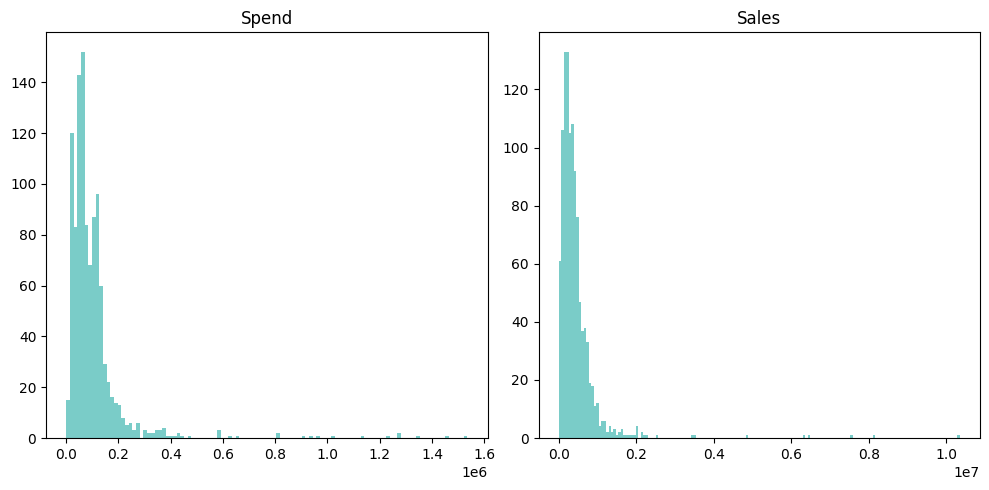

In [26]:
## Checkig all mediaData
plotHist(mediaData, columns = ['spend', 'sales'], titlesPlots=['Spend', 'Sales'])

In [27]:
#mediaList  = mediaData['media_origin'].unique()

#for m in mediaList:
#  filterData = mediaData[mediaData['media_origin']==m]
#  plotHist(filterData, columns = ['spend', 'sales'], titlesPlots=[ m+' Spend', m+' Sales'])

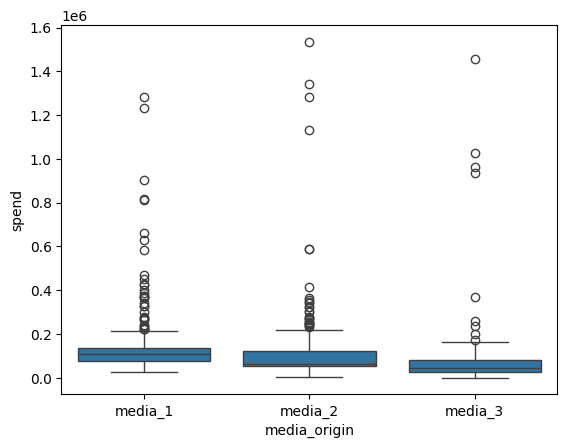

In [28]:
## It looks like that mediaData has outliers Im going to check the media origins
plotBox(df= mediaData, x='media_origin', y ='spend' , colorCol=None)

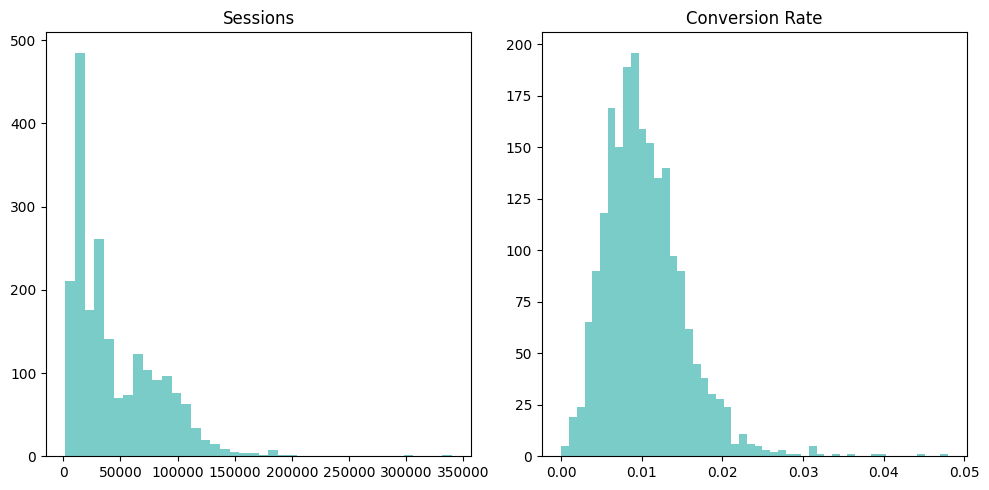

In [29]:
## Checking seasonality Data
plotHist(seasonalityData, columns = ['sessions', 'conversion_rate'], titlesPlots=['Sessions', 'Conversion Rate'])

It appears that all datasets have outliers, i will check if is related to time

In [30]:
def timePlotGrouped(df, groupedCol, dateCol, variableCol, xlab, ylab, title):
  data = df.groupby(groupedCol)
  fig, ax = plt.subplots(figsize=(10, 5))
  for key, group in data:
    ax.plot(group[dateCol], group[variableCol], label=key)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)
  ax.legend()
  ax.grid(True)
  plt.show()


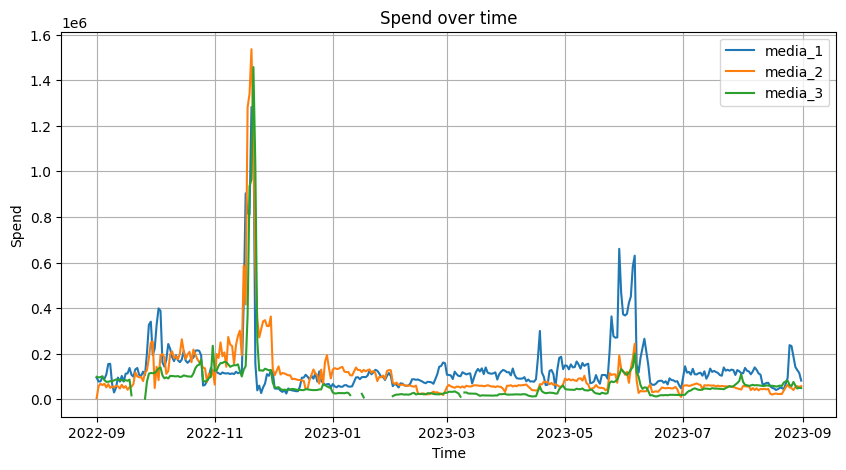

In [31]:
timePlotGrouped(df= mediaData, groupedCol='media_origin', dateCol='date',
                variableCol='spend', xlab='Time', ylab='Spend', title='Spend over time')

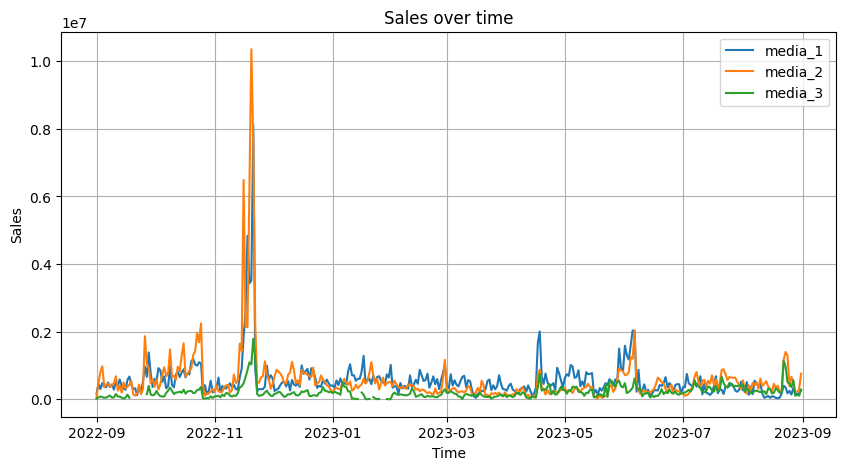

In [32]:
timePlotGrouped(df= mediaData, groupedCol='media_origin', dateCol='date',
                variableCol='sales', xlab='Time', ylab='Sales', title='Sales over time')

In [33]:
## What are the missing values?, let's check the values from maximun to minimum
mediaData.groupby('date').agg({'spend':'sum', 'sales': 'sum'}).sort_values(by='spend', ascending=False)


,spend,sales
date,,
2022-11-21,3820834.0,17481073.0
2022-11-20,3782325.0,14893014.0
2022-11-19,3085248.0,10859502.0
2022-11-18,2466398.0,7829815.0
2022-11-22,1769063.0,4356783.0
...,...,...
2023-02-18,114656.0,854203.0
2023-06-15,113384.0,516658.0
2023-06-16,110236.0,626672.0


It looks like that November was the monst successful month, but maybe it is an outlier, let´s check the another dataset if we can check that November is the most successful month

<Axes: xlabel='date', ylabel='sessions'>

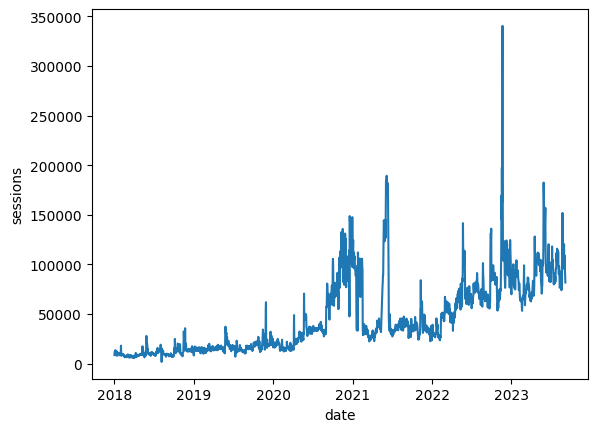

In [34]:
sns.lineplot(x='date', y='sessions', data=seasonalityData)

<Axes: xlabel='date', ylabel='conversion_rate'>

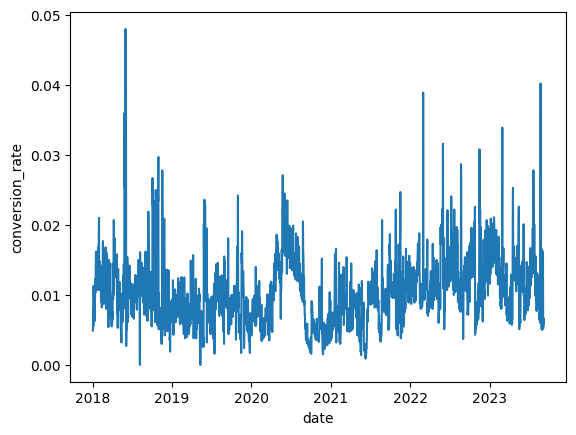

In [35]:
sns.lineplot(x='date', y='conversion_rate', data=seasonalityData)

In [36]:
#seasonalityData['date_month']= pd.to_datetime(seasonalityData['date']).dt.to_period('m')
seasonalityData['date_month'] = seasonalityData['date'].dt.month
seasonalityData['date_year']= pd.to_datetime(seasonalityData['date']).dt.to_period('Y')


In [37]:
'''
seasonalityData.pivot_table(
    values='sessions', index='date_year', columns='date_month',
    aggfunc='mean'
)
'''

"\nseasonalityData.pivot_table(\n    values='sessions', index='date_year', columns='date_month',\n    aggfunc='mean'\n)\n"

In [38]:
mediaDataGrouped = mediaData.groupby('date').agg({'spend': 'sum', 'sales':'sum'})

In [39]:
mediaDataGrouped = pd.merge(mediaDataGrouped, seasonalityData, on='date')

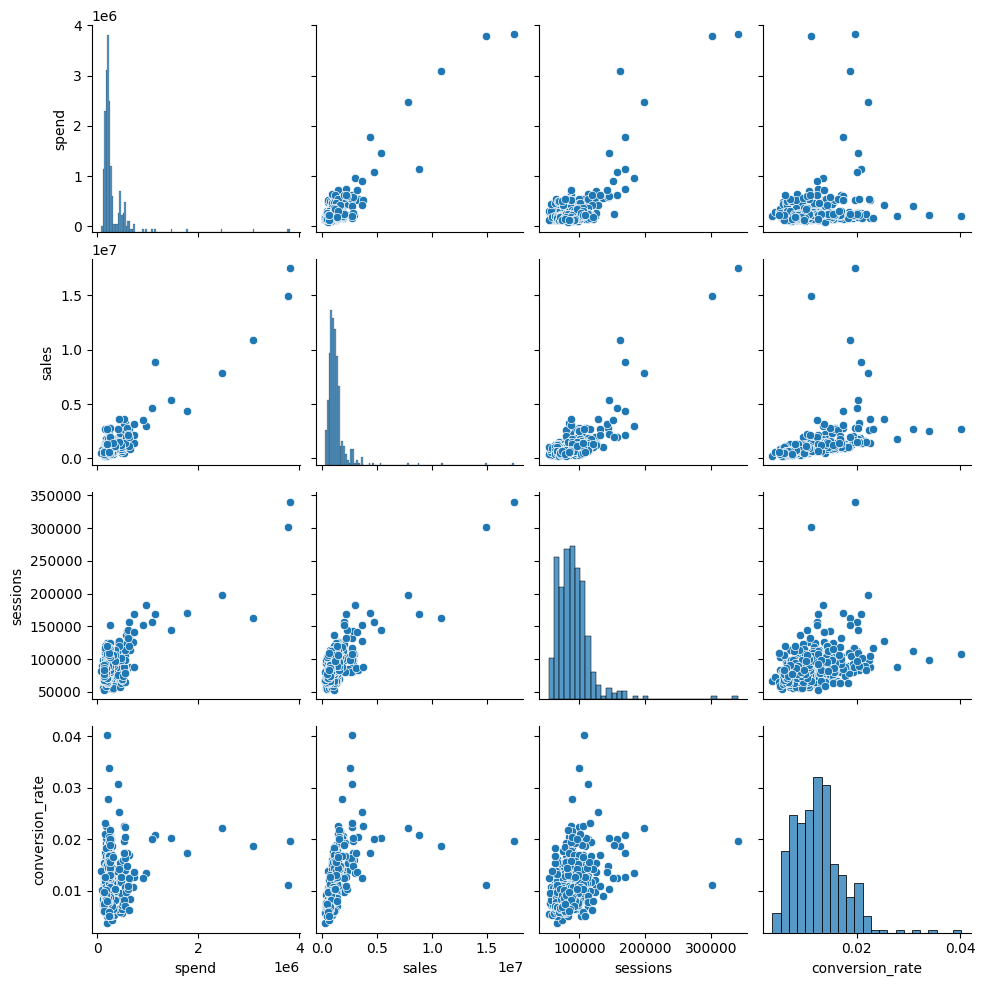

In [40]:
sns.pairplot(mediaDataGrouped, vars= ['spend', 'sales', 'sessions', 'conversion_rate'])
plt.show()

##### My opinion about the outliers


Looking at the values as such with an histogram or a boxplot, it seems that there are outliers ant it would be good to eliminate them with interquartile ranges.
However, when doing the pairplot I observe that there is an increase in spend and correlates with sessions and sales.
It seems that, although they are outliers, it would be wrong to eliminate them
Ir order to make the model, it would be better to add an extra column, that base on interquartile ranges, helps me to detect when the perios of maximum investment were.

In [41]:
## Function to create the column that detects the maximun dates of investment based on spend

def getLabelHighInvestmentPeriods(df, column, threshold=1.5):
  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)
  IQR = q3-q1
  # I need to create a maximun, that is the reason of this threshold
  highInvestmentThreshold = q3 + threshold * IQR
  df['high_investment'] = (df[column] > highInvestmentThreshold).astype(int)
  return df



In [42]:
mediaData=getLabelHighInvestmentPeriods(mediaData, column= 'spend')

In [43]:
mediaData = mediaData[['date', 'spend', 'sales', 'media_origin', 'high_investment']]

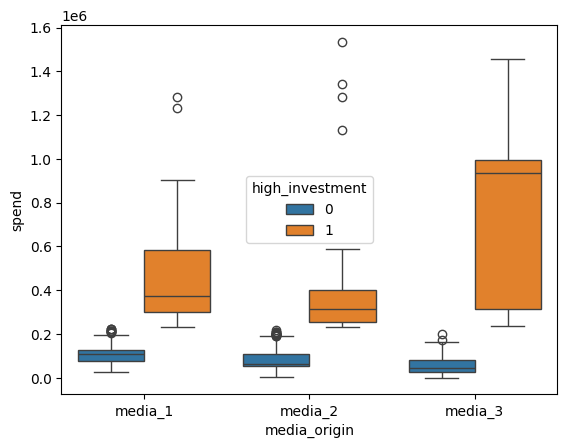

In [44]:
plotBox(df= mediaData, x='media_origin', y ='spend',colorCol='high_investment')

Ok, it looks like that the function works, now we need to check if there are missing data

#### Detecting missing data

Now that we detect the outliers and modify the dataset according the findings,
its necessary to detect if we have missing data

In [45]:
## Function to detect misssing data from grouped values
def detectMissingGrouped(df, groupedColumns):
  nullCounting = df.groupby(groupedColumns).agg(lambda column: column.isna().sum())
  return nullCounting

In [46]:
from google.colab import data_table
data_table.enable_dataframe_formatter()


In [47]:
detectMissingGrouped(df = mediaData, groupedColumns=['media_origin'])


,date,spend,sales,high_investment
media_origin,,,,
media_1,0,0,0,0
media_2,0,0,0,0
media_3,0,23,11,0


In [48]:
pd.DataFrame(seasonalityData.isna().sum())

,0
date,0
sessions,0
conversion_rate,0
date_month,0
date_year,0


##### Notes about missing data
In the dataset with name seasonalityData it has no problems with missing values.
The another dataset called mediaData does have missing values but only in one category, the category that I called "media_origin_3"
The missing values belongs to the columns called "sales" and "spend".
We have different methods to handling missing values.
Since simple methods like average or median, or techniques based on interpolation or even more complicated techniques like predictive models based on regressions


In this case I'm going to use the interpolation method


In [49]:
def interpolateColumn(df, columnToInterpolate, newcolumnName, interpolateMethod):
  df[newcolumnName] = df[columnToInterpolate].interpolate(method=interpolateMethod)
  return df

I'm going to test with the spend column and check the time series to check the missing values

For this i'm, going to create a new column with two values "was a missing value", 'no missing value' and compare in the chart, also in the average and median
If this is ok, I'm going to apply this technique to the original columns "sales" and "spend"

In [50]:
test= mediaData.copy()
test = interpolateColumn(test, columnToInterpolate='spend',
                              newcolumnName='spending_test', interpolateMethod='linear')


test['missing_category'] = np.where(test['spend'].isna(), 'was a missing value', 'no missing value')
test= test[test['media_origin']=='media_3']


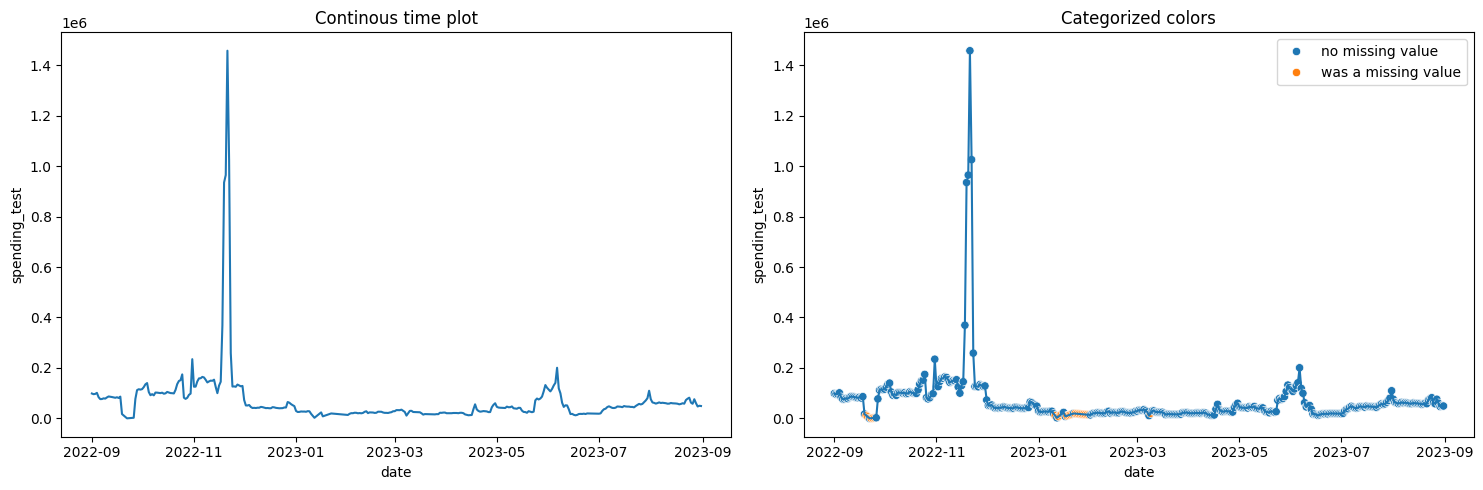

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot( x='date', y='spending_test', data=test, ax= axes[0]).set_title("Continous time plot")
sns.scatterplot(x='date', y='spending_test', hue='missing_category',
                data=test, ax=axes[1], alpha=1)
sns.lineplot( x='date', y='spending_test', data=test, ax= axes[1]).set_title("Categorized colors")
plt.tight_layout()
plt.show()


##### More notes about missing values


It seems that the interpolation method has worked, it is time to apply it to both columns.

In [52]:
mediaData = interpolateColumn(mediaData, columnToInterpolate='spend',
                              newcolumnName='spend', interpolateMethod='linear')

mediaData = interpolateColumn(mediaData, columnToInterpolate='sales',
                              newcolumnName='sales', interpolateMethod='linear')


#### Data Manipulation

I have a problem, the media dataset is divided by media origin
The seasonality data does not have this division
We need to create a proportion of conversion rate and sessions based on media data
Steps

- I need to calculate the percent spend by day and media origin
- After of that I need to muliply  the sessions and the conversion rate by the percentage od spend and media_origin

In [53]:
dailySpendTotal = mediaData.groupby('date')['spend'].transform('sum')

In [54]:
mediaData['spend_percentage'] = mediaData['spend']/dailySpendTotal

mainData = pd.merge(mediaData, seasonalityData, on='date')
mainData['sessions_media'] = mainData['sessions'] * mainData['spend_percentage']
mainData['conversion_rate_media'] = mainData['conversion_rate'] * mainData['spend_percentage']


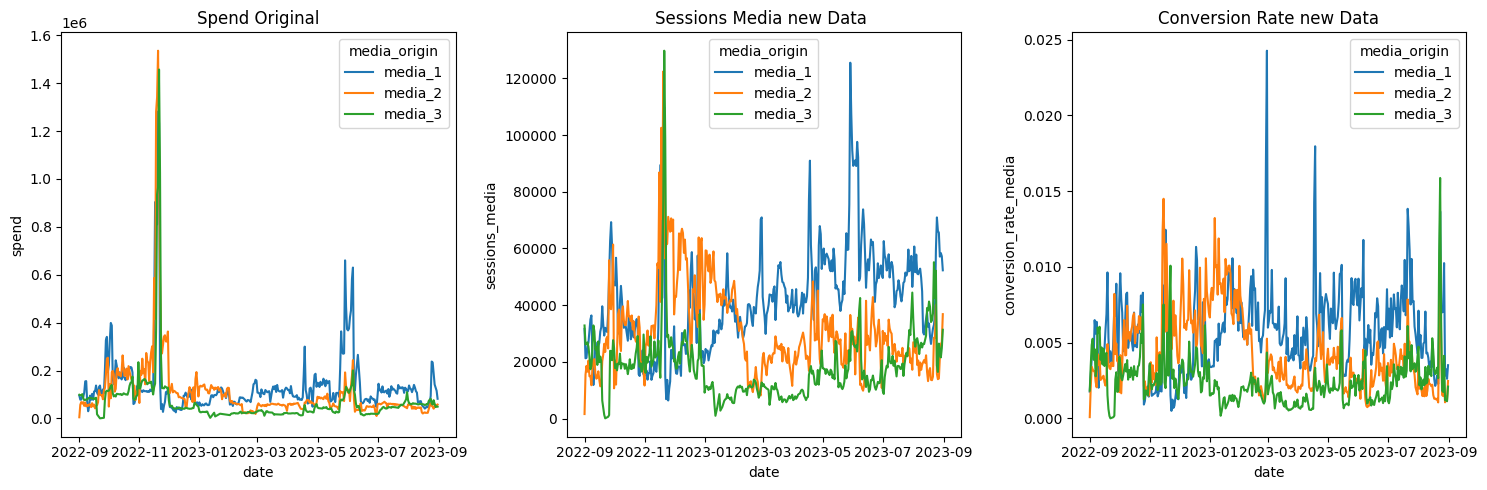

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot( x='date', y='spend', hue='media_origin', data=mainData, ax= axes[0]).set_title("Spend Original")
sns.lineplot( x='date', y='sessions_media', hue='media_origin',  data=mainData, ax= axes[1]).set_title("Sessions Media new Data ")
sns.lineplot( x='date', y='conversion_rate_media', hue='media_origin', data=mainData, ax= axes[2]).set_title("Conversion Rate new Data")
plt.tight_layout()
plt.show()

In [56]:
## I'm going to delete the original columns and rename the new ones as the old ones
mainData =  mainData[['date', 'date_month', 'date_year', 'spend', 'sales',
                      'media_origin', 'high_investment', 'sessions_media',
                      'conversion_rate_media']]

mainData = mainData.rename(columns={'sessions_media': 'sessions', 'conversion_rate_media':'conversion_rate'})

In [57]:
#mainData = pd.merge(mediaData, seasonalityData, on='date')
#mainData.shape
#mainData.columns
#mainData.head()

## Building the model

### What is the model that I choose?
To build this budget optimization model, I need to consider an approach where we distribute the daily budget between the different media channels (in the column 'media_origin') to maximise sales.
##### Steps
What I need to build this model?


*   An objective function that maximises sales based on daily expenditure
*   Constraints based on the total daily budget and the distribution structure between media channels






#### Description of the model

Let's begin to explain the model in some math terms.

**Main Explanation**

Giving a total budget that we call as ***P*** for a specific time period, we want to maximise the sales by allocatint the daily budget in the different channels that we called ***m*** during each day ***t*** in the selected period.


**Variables and Parameters:**

- ***(T)***: Total number of days in the period.
- ***(M)***: Category of media origin ('media_1', 'media_2')
- $\text{spend}_{t,m}$: Amount of budget allocated to the channel (m) on the day (t)
- $\text{sessions}_{t,m}$: Number of sessions on the media channel by day
- $\text{conversion_rate}_{t,m}$: Conversion rate by channel by day
- $\text{high_investment}_{t,m}$: A binary variable whether the day (t) is a period of high investment (1 means high investment, 0 otherwise)


**Target Function**
With this model we want to maximise the total sales, which can be approximated as the sum of the product of budget allocation, sessions and conversion rate on each channel and each day.

The objective function is:

$\text{Maximise sales} \quad \sum_{t=1}^T \sum_{m \in M} \text{spend}_{t,m} \cdot \text{sessions}_{t,m} \cdot \text{conversion_rate}_{t,m} $


**Some Restrictions of the model**

Daily budget restriction: The sum of the daily expenditure on all channels must not exceed the daily budget allowed, calculated as the tital budget divided by the number of days in the period

$\sum_{m \in M} \text{spend}_{t,m} \leq \frac{P}{T} \quad \forall t$

High spend restriction

On high spend days, the company must ensure that at least a minimun percentage of the daily budget is allocated to channels labelled as high spend.

$\text{spend}_{t,m} \geq \alpha \cdot \frac{P}{T} \text{ if }  \text{high_investment}_{t,m} = 1$


Where $\alpha$ is the minimum daily investment percentage for high investment days


#### Coding the model

In [58]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


In [59]:
import scipy.stats
#scipy.stats.pearsonr(mainData['spend'], mainData['sales'])


In [60]:
mainData.head(20)

,date,date_month,date_year,spend,sales,media_origin,high_investment,sessions,conversion_rate
0,2022-09-01,9,2022,95113.0,165879.0,media_1,0,31617.821552,0.001772
1,2022-09-02,9,2022,78221.0,455400.0,media_1,0,21266.633413,0.002840
2,2022-09-03,9,2022,78675.0,302078.0,media_1,0,21422.258493,0.003934
3,2022-09-04,9,2022,96216.0,477936.0,media_1,0,25515.149915,0.004998
4,2022-09-05,9,2022,89380.0,376129.0,media_1,0,26863.595354,0.004105
5,2022-09-06,9,2022,108475.0,354800.0,media_1,0,30980.248913,0.006494
6,2022-09-07,9,2022,154719.0,492299.0,media_1,0,34986.043636,0.005604
7,2022-09-08,9,2022,155849.0,361954.0,media_1,0,36367.294295,0.006383
8,2022-09-09,9,2022,67263.0,436958.0,media_1,0,21170.307941,0.005140
9,2022-09-10,9,2022,29969.0,282276.0,media_1,0,11828.203730,0.002030


First we need also a model to predict the sales based on spend,
sessions and conversion rate, here are the details and the evaluation of the simple model.
I'm testing several models
- Linear Models (I deleted the code)
- Lasso Regression
- XgBoost


In [61]:
X= mainData[['spend', 'sessions', 'conversion_rate']]
#X= mainData[['spend']]

y = mainData['sales']
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=50)

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar la importancia de las variables
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})


           feature  importance
0            spend    0.640696
1         sessions    0.143179
2  conversion_rate    0.216125


In [64]:
## It looks like that spend is the most important variable
## So sessions and conversion rate looks important (a value less than 0.05 could be considered as non important)
feature_importance

,feature,importance
0,spend,0.640696
1,sessions,0.143179
2,conversion_rate,0.216125


I'm going to start with the Lasso regression

In [65]:
alphas = np.logspace(-3, 1, 10)
lasso = Lasso()
paramGrid = {'alpha': alphas}

In [ ]:
gridSearch = GridSearchCV(lasso, paramGrid, cv=5, scoring='neg_mean_absolute_error')
gridSearch.fit(X_train, y_train)

# Best alpha valus for the regression
best_alpha = gridSearch.best_params_['alpha']
print(f"Mejor valor de alpha: {best_alpha}")

Mejor valor de alpha: 10.0


In [ ]:
'''
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train, y_train)
y_pred_best = lasso_best.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
mape = mean_absolute_percentage_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Resultados con el mejor alpha:")
print(f"MAE: {mae_best}")
print(f"MSE: {mse_best}")
print(f"RMSE: {rmse_best}")
print(f"MAPE: {mape}")
print(f"R²: {r2_best}")
'''

'\nlasso_best = Lasso(alpha=best_alpha)\nlasso_best.fit(X_train, y_train)\ny_pred_best = lasso_best.predict(X_test)\nmae_best = mean_absolute_error(y_test, y_pred_best)\nmse_best = mean_squared_error(y_test, y_pred_best)\nmape = mean_absolute_percentage_error(y_test, y_pred_best)\nrmse_best = np.sqrt(mse_best)\nr2_best = r2_score(y_test, y_pred_best)\n\nprint(f"Resultados con el mejor alpha:")\nprint(f"MAE: {mae_best}")\nprint(f"MSE: {mse_best}")\nprint(f"RMSE: {rmse_best}")\nprint(f"MAPE: {mape}")\nprint(f"R²: {r2_best}")\n'

In [ ]:
def linearLassoModel(df,alphaValue):
  #x = df[['spend', 'sessions', 'conversion_rate']]
  x = df[['spend']]
  y = df['sales']
  lassoModel = Lasso(alpha=alphaValue)
  lassoModel.fit(x,y)
  return lassoModel

In [ ]:
LassoModel = linearLassoModel(mainData, alphaValue=best_alpha)

In [ ]:
#LassoCoefSpend, LassoCoefSessions, LassoCoefConversionRate = LassoModel.coef_
LassoCoefSpend = LassoModel.coef_


In [ ]:
y_pred = LassoModel.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)



mae, mse, rmse, r2

(208493.0942533969, 178590527272.76584, 422599.7246482371, 0.6428367296743616)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [ ]:
xgb_base = XGBRegressor(random_state=42)

# Definir el rango de hiperparámetros para probar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=xgb_base, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.6}


In [ ]:
#xgbModel = XGBRegressor(n_estimators=100, learning_rate=0.1,
#                        max_depth=5, random_state=42)

xgbModel = XGBRegressor(**best_params, random_state=42)

In [ ]:
xgbModel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgbModel.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)



mae, mse, rmse, r2

(193350.57347741787,
 192978730481.18103,
 439293.44461439556,
 0.6140617560489208)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Definir la arquitectura de la red neuronal
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

# Compilar y entrenar el modelo
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)

# Predecir en el conjunto de prueba
y_pred = nn_model.predict(X_test)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 436659912704.0000 - val_loss: 635567276032.0000
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 291747692544.0000 - val_loss: 455511834624.0000
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 194717564928.0000 - val_loss: 296920907776.0000
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137148841984.0000 - val_loss: 262877085696.0000
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132338065408.0000 - val_loss: 262791200768.0000
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131976962048.0000 - val_loss: 264579268608.0000
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106590314496.0000 - val_loss: 262748667904.0000
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111620849664.0000 - val_loss: 263468023808.0000
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127365685248.0000 - val_loss: 263026229248.0000
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

In [ ]:
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)



mae, mse, rmse, r2

(212153.93077357332, 269733305140.49966, 519358.5516196876, 0.46056025002612)

In [ ]:
from lightgbm import LGBMRegressor

# Entrenar el modelo de LightGBM
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgb_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = lgb_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 821, number of used features: 3
[LightGBM] [Info] Start training from score 440793.814251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)



mae, mse, rmse, r2

(212153.93077357332, 269733305140.49966, 519358.5516196876, 0.46056025002612)

In [ ]:
### Main function of the model
def optimizingBudgetDistribution(df, totalBudget, startDate, endDate):
  selectedDates = df[(df['date']>= startDate) & (df['date']<= endDate)]
  ## Let´s create the modelo
  model = LpProblem('Budget_Optimization', LpMaximize)

  spendVars= {}
  for _, row in selectedDates.iterrows():
    for media in selectedDates['media_origin'].unique():
      varName = f"spend_{row['date']}_{media}"
      spendVars[(row['date'], media)] = LpVariable(varName, lowBound = 0, cat='Continuous')

  #model += lpSum(
  #              ##predictSales(spendVars[(row['date'], media)].varValue, row['sessions'], row['conversion_rate'])
  #              spendVars[(row['date'], media)] *row['conversion_rate']*row['sessions']
  #              for _, row in selectedDates.iterrows()
  #              for media in selectedDates['media_origin'].unique()
  #)
  model += lpSum(
                (LassoCoefSpend * spendVars[(row['date'], media)]+
                 LassoCoefSessions*row['sessions'] +
                 LassoCoefConversionRate*row['conversion_rate'])
                for _, row in selectedDates.iterrows()
                for media in selectedDates['media_origin'].unique()
  )


  #print(model)
  ### Restrictions of the model
  ##### Daily budget
  dailyBudget = totalBudget / len(selectedDates['date'].unique())
  for date in selectedDates['date'].unique():
      model += lpSum(spendVars[(date, media)]
                     for media in selectedDates['media_origin'].unique()) <= dailyBudget, f"budget_constraint_{date}"

  ##### High investment
  for _, row in selectedDates.iterrows():
    if row['high_investment']==1:
      for media in selectedDates['media_origin'].unique():
        model += spendVars[(row['date'], media)]>= (totalBudget/len(selectedDates['date'].unique())) * 0.1, f"high_investment_{row['date']}_{media}"
  ## The model could allocate more spend on a single media, it is necessary to avoid this
  maxSpendPercentage = 0.5
  for date in selectedDates['date'].unique():
    for media in selectedDates['media_origin'].unique():
      model += spendVars[(date, media)] <= dailyBudget * maxSpendPercentage, f"max_spend_{date}_{media}"

  ### End of the model
  model.solve()

  allocation = []
  for (date, media), var in spendVars.items():
    allocation.append({'date':date, 'media_origin': media, 'allocated_spend': var.varValue})

  dfModel = pd.DataFrame(allocation)
  return dfModel



## Testing the model

In [ ]:
avgBudget = np.mean(mainData['spend'])
maxBudget = np.max(mainData['spend'])
minBudget = np.min(mainData['spend'])


In [ ]:
#mainData['date'].unique()
trainData = mainData[mainData['date']< '2023-02-01']
testData = mainData[mainData['date']>= '2023-02-01']
testBudget = maxBudget

In [ ]:
print(trainData.shape)
print(testData.shape)

(459, 9)
(636, 9)


In [ ]:
Xtrain = trainData[['spend', 'sessions', 'conversion_rate']]
ytrain = trainData['sales']
lassoModelTrain = Lasso(alpha= best_alpha)
lassoModelTrain.fit(Xtrain, ytrain)


Lasso(alpha=10.0)

In [ ]:
lassoCoefSpendTrain, lassoCoefSessionsTrain, lassoCoefConversionTrain = lassoModelTrain.coef_

In [ ]:
optimizedAllocation = optimizingBudgetDistribution(df=testData, totalBudget=testBudget,
                                               startDate='2023-02-01', endDate='2023-02-10')

In [ ]:
testData = testData.merge(optimizedAllocation, on=['date', 'media_origin'],
                          how='left')



In [ ]:
testData['projected_sales'] = (lassoCoefSpendTrain*testData['allocated_spend'] +
                               lassoCoefSessionsTrain*testData['sessions'] +
                               lassoCoefConversionTrain*testData['conversion_rate']

)

In [ ]:
testData= testData.dropna()

In [ ]:
maeTest = mean_absolute_error(testData['sales'], testData['projected_sales'])
mseTest = mean_squared_error(testData['sales'], testData['projected_sales'])
rmseTest = np.sqrt(mseTest)
mapeTest = mean_absolute_percentage_error(testData['sales'], testData['projected_sales'])


In [ ]:
print(f"MAE: {maeTest}")
print(f"MSE: {mseTest}")
print(f"RMSE: {rmseTest}")
print(f"MAPE: {mapeTest}")


MAE: 145586.89489106543
MSE: 28403930118.9686
RMSE: 168534.6555429138
MAPE: 0.6063697783778994


In [ ]:
actualSales = testData['sales'].sum()
predictedSales = testData['projected_sales'].sum()
incrementalSales = predictedSales - actualSales
print(f"Real Sales: {actualSales}")
print(f"Predicted Sales: {predictedSales}")
print(f"Incremental Sales: {incrementalSales}")


Real Sales: 9193030.0
Predicted Sales: 10412338.402532734
Incremental Sales: 1219308.402532734


## Evaluate the model with an interactive example

## Conclusions

## References



1.   https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
2.   https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python
3. https://cienciadedatos.net/documentos/py31-optimizacion-presupuesto-campa%C3%B1as-marketing.html
4. https://realpython.com/linear-programming-python/
5. https://copa-uniandes.github.io/optimizacion/intro.html




